# 環境確認

In [3]:
import sys
import torch

print("Pythonのバージョン：",sys.version)
print("PyTorchのバージョン：", torch.__version__)
print("使用しているGPUの確認")
!nvidia-smi

Pythonのバージョン： 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
PyTorchのバージョン： 1.11.0+cu113
使用しているGPUの確認
Wed May 25 13:21:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----

# データのダウンロード

In [4]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Download 100%.


In [5]:
! signate list
! signate files --competition-id=133
! signate download --competition-id=133

  competitionId  title                                                                             closing     prize                 submitters
---------------  --------------------------------------------------------------------------------  ----------  ------------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                              -                                       5648
             24  【練習問題】お弁当の需要予測                                                      -                                       7037
             27  【練習問題】Jリーグの観客動員数予測                                               -                                       1698
            100  【練習問題】手書き文字認識                                                        -           Knowledge                    221
            102  【練習問題】タイタニックの生存予測                                                -           Knowledge                   1510
            103  【練習問題】音楽ラベリング                                         

In [6]:
!unzip train_images.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: train_images/train_0.jpg  
  inflating: train_images/train_1.jpg  
  inflating: train_images/train_10.jpg  
  inflating: train_images/train_100.jpg  
  inflating: train_images/train_1000.jpg  
  inflating: train_images/train_1001.jpg  
  inflating: train_images/train_1002.jpg  
  inflating: train_images/train_1003.jpg  
  inflating: train_images/train_1004.jpg  
  inflating: train_images/train_1005.jpg  
  inflating: train_images/train_1006.jpg  
  inflating: train_images/train_1007.jpg  
  inflating: train_images/train_1008.jpg  
  inflating: train_images/train_1009.jpg  
  inflating: train_images/train_101.jpg  
  inflating: train_images/train_1010.jpg  
  inflating: train_images/train_1011.jpg  
  inflating: train_images/train_1012.jpg  
  inflating: train_images/train_1013.jpg  
  inflating: train_images/train_1014.jpg  
  inflating: train_images/train_1015.jpg  
  inflating: train_images/train_1016.jpg  
  inflating: train_images/train_

In [7]:
# ディレクトリ内のデータの確認
%ls

label_master.tsv  sample_submit.tsv  train_images/     train_master.tsv
sample_data/      test_images.zip    train_images.zip


# 事前準備

In [8]:
# ライブラリのインポート
import os
import random
from glob import glob
from warnings import filterwarnings

import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchsummary import summary

from collections import defaultdict

filterwarnings('ignore')  # warningをオフにする

# ランダムシードの設定
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [9]:
# 初期設定
COLAB_FLG = True  # COLABで実行する場合はTrue, それ以外で実行する場合はFalse

if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/gdrive') # マウント先
    ATTACH_PATH = '/content/gdrive/MyDrive/CIFAR10-Pytorch'  # 保存先のベースディレクトリ
else:
    ATTACH_PATH = '.'  # ローカルならカレントディレクトリ
    
    
SAVE_MODEL_PATH = f'{ATTACH_PATH}/model/'  # モデルの保存先

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)

Mounted at /content/gdrive


In [10]:
# デバイスの設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {} # GPUが使える場合、DataLoaderでのミニバッチの取り出しを高速化
print(f'デバイス：{device}')

デバイス：cuda


## 定数の設定

In [11]:
# 画像データのディレクトリ
img_dir = 'train_images/' # 画像データのディレクトリ

# 学習済み
pretrained = True

# モデル名
model_name = 'vgg16_finetuning'

In [12]:
# ハイパーパラメータの設定
parser = argparse.ArgumentParser()
parser.add_argument('--test_size', type=float, default=0.25)
parser.add_argument('--image_size', type=int, default=96)
parser.add_argument('--num_classes', type=int, default=10)
parser.add_argument('--epochs', type=int, default=300)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--lr', type=float, default=1e-3) # 学習率
parser.add_argument('--mode', type=str, default='max') # スケジューラの監視対象
parser.add_argument('--factor', type=float, default=0.5) # スケジューラの学習率を減衰させる割合
parser.add_argument('--lr_patience', type=int, default=5) # スケジューラの監視対象回数
parser.add_argument('--threshold', type=float, default=1e-5) # スケジューラの監視対象回数
parser.add_argument('--patience', type=int, default=20) # earlystoppingの監視対象回数
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, epochs=300, factor=0.5, image_size=96, lr=0.001, lr_patience=5, mode='max', num_classes=10, patience=20, test_size=0.25, threshold=1e-05)


# Dataset, Dataloader

## データの読み込み

In [13]:
# ラベルデータの読み込み
train_master = pd.read_csv('train_master.tsv', sep='\t')
print(train_master.head())
print('データ数: ', train_master.shape[0])

     file_name  label_id
0  train_0.jpg         1
1  train_1.jpg         5
2  train_2.jpg         1
3  train_3.jpg         6
4  train_4.jpg         3
データ数:  5000


In [14]:
# 画像データの名前リストの抽出
image_name_list = train_master['file_name'].values
print('データ数: ', len(image_name_list))

# ラベルリストの抽出
label_list = train_master['label_id'].values

データ数:  5000


In [15]:
# 学習データと検証データに分割
x_train, x_val, y_train, y_val = train_test_split(image_name_list, label_list, test_size=opt.test_size, stratify=label_list, random_state=42)

## transform

In [16]:
# transformの設定
transform = {
    'train': transforms.Compose([
        transforms.Resize(opt.image_size),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1.5)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    'val': transforms.Compose([
        transforms.Resize(opt.image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
}

## Dataset

In [17]:
# Datasetの設定
class CifarDataset(Dataset):
    def __init__(self, image_name_list, label_list, img_dir, transform=None, phase=None):
        self.image_name_list = image_name_list # 画像ファイル名
        self.label_list = label_list # ラベル
        self.img_dir = img_dir # 画像データのディレクトリ
        self.phase = phase # 変数phaseで学習(train)もしくは検証(val)の設定を行う
        self.transform = transform

    def __len__(self):
        return len(self.image_name_list) # 1エポックあたりに読み込むデータ数として、入力データの数を指定

    def __getitem__(self, index):
        
        # index番目の画像を読み込み、前処理を行う
        image_path = os.path.join(self.img_dir, self.image_name_list[index]) # train_master.iloc[index, 0]はファイル名を抽出
        img = Image.open(image_path)
        img = self.transform[self.phase](img)
        
        # index番目のラベルを取得する
        label = self.label_list[index]
        
        return img, label

In [18]:
# Datasetのインスタンス作成
train_dataset = CifarDataset(x_train, y_train, img_dir, transform=transform, phase='train')
val_dataset = CifarDataset(x_val, y_val, img_dir, transform=transform, phase='val')

## DataLoader

In [19]:
# Dataloader
dataloader = {
    'train': DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=opt.batch_size, shuffle=False)
}

# EarlyStopplingクラス

In [20]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            self.epoch += 1 # カウンターを1増やす
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                if self.verbose: # 早期終了のフラグが1の場合
                    print('early stopping') # メッセージを出力
                return True # 学習を終了するTrueを返す
        # 前エポックの損失以下の場合
        else:
            self.epoch = 0               # カウンターを0に戻す
            self.pre_loss = current_loss # 損失の値を更新する
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

# モデルの定義

In [21]:
# 学習済みモデルの読み込み
model = models.vgg16(pretrained=pretrained)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [22]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=opt.num_classes) # 最終レイヤー関数の付け替え
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
# モデルをGPUに送る
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
# ネットワークを可視化する
summary(model, (3, opt.image_size, opt.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

# ファインチューニング

In [26]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)

params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

# 学習

In [27]:
# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
])

In [28]:
# 収束が停滞したら学習率を減衰するスケジューラー
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,   # オプティマイザーを指定
    mode=opt.mode,  # 監視対象は最大値
    factor=opt.factor,  # 学習率を減衰する割合
    patience=opt.lr_patience, # 監視対象のエポック数
    min_lr=opt.threshold, # 最小学習率
    verbose=True # 学習率を減衰した場合に通知する
)

In [29]:
# 学習履歴を保存するdictオブジェクト
history = defaultdict(list)

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=opt.patience, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力

# 学習モデルの定義
def train_model(model, epochs, loss_fn, optimizer):
    
    # ベストスコアの初期化
    best_loss = np.inf
    
    # エポックループの設定
    for epoch in range(epochs):
        
        # 現在のエポック数の出力
        print(f'Epoch: {epoch+1} / {epochs}')
        print('--------------------------')
        
         # 毎エポック: 学習・検証ループの設定
        for phase in ['train', 'val']:
            
            # 学習モード、検証モードの切替
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 損失値のリセット
            epoch_loss = 0.0
            # 正解数
            corrects = 0
            # 予測値リストのリセット
            pred_list = []
            # 正解値リストのリセット
            true_list = []
            
            # dataloaderから、ミニバッチ(batch_size)単位でのデータの読み込み
            for images, labels in dataloader[phase]:
                
                # 入力データ、正解ラベルをモデルと同じdeviceへ移動
                images = images.to(device)
                labels = labels.to(device)
                
                # 勾配情報の初期化
                optimizer.zero_grad()
                
                # 学習時のみ勾配情報を有効に
                with torch.set_grad_enabled(phase=='train'):
                    
                    # モデルによる計算
                    outputs = model(images)
                    # 損失値の計算
                    loss = loss_fn(outputs, labels)
                    # 予測ラベルの算出
                    preds = torch.argmax(outputs, dim=1) # 予測値を出力
                    
                    # 学習時のみ、バックプロパゲーションとパラメータ更新
                    if phase == 'train':
                        
                        # 誤差逆伝播法により勾配の算出
                        loss.backward()
                        # optimizerのパラメータ更新
                        optimizer.step()
                    
                    # 損失値の追加
                    epoch_loss += loss.item() * images.size(0)
                    
                    # 正解数の追加
                    corrects += torch.sum(preds == labels.data)                    
                    
                    # 予測ラベルの追加
                    preds = preds.to('cpu').numpy()
                    pred_list.extend(preds)
                    
                    # 正解ラベルの追加
                    labels = labels.to('cpu').numpy()
                    true_list.extend(labels)
            
            # 1エポック内における損失値の平均
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            
            # 正解率の算出
            accuracy = corrects.double() / len(dataloader[phase].dataset)
            accuracy = accuracy.to('cpu').detach().numpy().copy()
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(accuracy)
            
            # 各評価スコアの出力
            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f}')
            
            # 検証時、検証スコアとベストスコアの大小比較を行う
            if (phase == 'val') and (epoch_loss < best_loss):
                
                ## 検証スコアが改善した場合のみ以下の処理を行う
                
                # ベストスコアの更新
                best_loss = epoch_loss
                # パラメータの名前を指定
                param_name = f'{SAVE_MODEL_PATH}{model_name}.pth'
                # パラメータの保存
                torch.save(model.state_dict(), param_name)
        
        # スケジューラー、テストデータの精度を監視する
        scheduler.step(epoch_loss)

        # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
        if (phase == 'val') and ers(epoch_loss):
            # 監視対象のエポックで損失が改善されなければ学習を終了
            break

In [30]:
# モデルの学習と推論の実行
train_model(model, opt.epochs, criterion, optimizer)

Epoch: 1 / 300
--------------------------
train Loss: 1.3657 Accuracy: 0.5163
val Loss: 0.9835 Accuracy: 0.6744
Epoch: 2 / 300
--------------------------
train Loss: 0.9797 Accuracy: 0.6733
val Loss: 0.9057 Accuracy: 0.7376
Epoch: 3 / 300
--------------------------
train Loss: 0.9701 Accuracy: 0.6867
val Loss: 0.6839 Accuracy: 0.7864
Epoch: 4 / 300
--------------------------
train Loss: 0.7774 Accuracy: 0.7437
val Loss: 0.5490 Accuracy: 0.8304
Epoch: 5 / 300
--------------------------
train Loss: 0.7304 Accuracy: 0.7659
val Loss: 0.8415 Accuracy: 0.7920
Epoch: 6 / 300
--------------------------
train Loss: 0.7376 Accuracy: 0.7621
val Loss: 0.4866 Accuracy: 0.8416
Epoch: 7 / 300
--------------------------
train Loss: 0.6510 Accuracy: 0.7899
val Loss: 0.6084 Accuracy: 0.8104
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00007: reducing learning rate of group 1 to 2.5000e-04.
Epoch 00007: reducing learning rate of group 2 to 5.0000e-04.
Epoch: 8 / 300
---------------

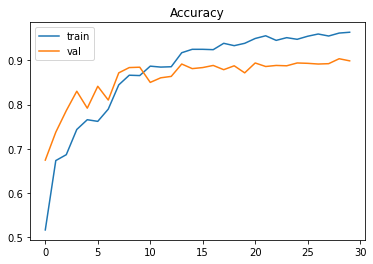

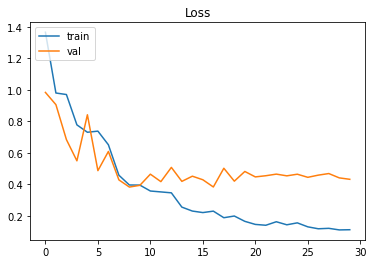

In [31]:
# 正解率の推移をプロット
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# ロスの推移をプロット
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()